### make regional bump charts of CSAO SIV data

In [1]:
import datetime
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from matplotlib import gridspec
import matplotlib.lines as mlines

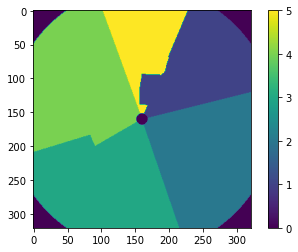

In [2]:
regions = np.array(Dataset('/Users/carmennab/Dropbox/michel_csao/regions_EASE.nc',"r")['Regions'])
regs = [1,2,3,4,5,[1,2,3,4,5]]
region_names =['Weddell Sea','King Haakon VII','East Antarctica','Ross and Amundsen Seas',
               'Amundsen-Bellingshausen Sea','All Regions']

plt.imshow(regions)
plt.colorbar()

#0: Ocean / higher latitude
#1: Weddell Sea
#2: King Haakon VII
#3: East Antarctica
#4: Ross and Amundsen Seas
#5: Amundsen-Bellingshausen Sea

### calculate grid cell area

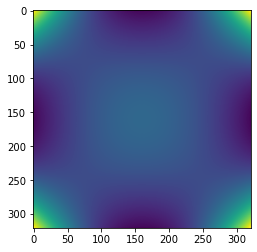

In [3]:
### code stolen from ReadBudgets-Pathfinder.ipynb - is this the right grid?

file = '/Users/carmennab/cpom_server/home/gch/SS_budget_23/grids_S/Pathfinder_gs_SH.npz'
npzfile =  np.load(file)

xdist = npzfile["xdist"]
ydist = npzfile["ydist"]
area=xdist*ydist

plt.imshow(area)

### calculate and plot regional ranked SIV - winter

In [4]:
datapath = '/Users/carmennab/cpom_server/home/gch/SS_budget_23/2024-08-15/data_out_smoothed/'
files = sorted(glob.glob(datapath+'*.nc'))
colors = ['#00441b','#006d2c','#238b45','#41ae76','#66c2a4','#99d8c9','#ccece6'] 
nums = ['(a)','(b)','(c)','(d)','(e)','(f)']

In [5]:
figpath = '/Users/carmennab/Dropbox/michel_csao/figures/'
for season, season_months,ymaxs,datelims in zip(['winter','summer'],[[4,5,6,7,8,9],[10,11,12,1,2,3]],
            [[8,6,3.5,8,2.5,30],[7,4,3,6,2,21]],[[380,260,180,400,120,1400],[300,170,150,300,90,1000]]):

    fig = plt.figure(figsize=(15,18))
    spec = gridspec.GridSpec(ncols=2, nrows=3, wspace=0.2,hspace=0.2)

    for count,region_name in enumerate(region_names):
        ymax = ymaxs[count]*1000
        ymin = 0

        all_vols = [] 

        for file in files:
            str_date = file.split('/')[9].split('_')[1].split('-')[0]
            date = datetime.datetime.strptime(str_date,"%Y%m%d").date()
            data = Dataset(file)

            sit = np.array(Dataset(file)['thickness'])
            conc = np.array(Dataset(file)['concentration'])

            sit[~np.isin(regions, regs[count])] = np.nan
            conc[~np.isin(regions, regs[count])] = np.nan

            vol = (conc * sit * area)
            tot_vol = np.nansum(vol) * 1e-9 # convert into km3

            d = {'date':date,'year':date.year,'month':date.month,'tot_vol':tot_vol}

            all_vols.append(d)

        ### create dataframe of all vols
        all_vols = pd.DataFrame(all_vols).sort_values(['month','year'])

        ### add SIV ranks to dataframe
        ranks = []
        for month in set(all_vols['month']):
            monthly_data = all_vols[all_vols['month']==month]
            rank=monthly_data['tot_vol'].rank(ascending=False)
            ranks.append(rank)

        all_vols['vol_rank'] = np.hstack(ranks)

        all_vols['vol_color'] = [colors[int(rank)-1] for rank in all_vols['vol_rank']]

        season_vols = all_vols[all_vols['month'].isin(season_months)]

        str_mid_dates = [f'{year}0601' for year in sorted(set(all_vols['year']))]
        mid_dates = [datetime.datetime.strptime(str_mid_date,"%Y%m%d").date() for str_mid_date in str_mid_dates]
        year_lengths = [365,365,366,365,365,365,366]

        ### plot
        ax = fig.add_subplot(spec[count])

        bars = ax.bar(mid_dates, np.full(len(mid_dates),ymax),alpha=0.5,width = year_lengths)
        bars[0].set_color('lightgrey')
        bars[1].set_color('snow')
        bars[2].set_color('lightgrey')
        bars[3].set_color('snow')
        bars[4].set_color('lightgrey')
        bars[5].set_color('snow')
        bars[6].set_color('lightgrey')

        for mid_date in mid_dates:
            ax.annotate(mid_date.year,(mid_date-datetime.timedelta(days=70),ymax-datelims[count]),c='black',fontsize=10)

        for month in season_months:
            monthly_data = season_vols[season_vols['month']==month]
            ax.plot(monthly_data['date'],monthly_data['tot_vol'],c='#41ae76',alpha=0.5)

        ax.scatter(season_vols['date'], season_vols['tot_vol'], c=season_vols['vol_color'], s=200)

        for month,date,vol in zip(season_vols['month'],season_vols['date'],season_vols['tot_vol']):
            ax.annotate(int(month),(date-datetime.timedelta(days=30),vol-40),c='white',fontsize=10)

        if count in [0,2,4]:
            ax.set_ylabel('Sea ice volume (km${^3}$)',fontsize=20,labelpad=20)
        ax.tick_params(
            axis='x',          # changes apply to the x-axis
            which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False) # labels along the bottom edge are off
        ax.set_ylim([ymin,ymax])
        ax.set_title(f'{nums[count]} {region_name}',fontsize=20,pad=10)
        ax.tick_params(axis='y', labelsize=10)
        if count in [2,4]:
            ax.set_yticks(np.arange(ymin,ymax+500,500))
        elif count == 5:
            ax.set_yticks(np.arange(ymin,ymax+3000,3000))
        else:
            ax.set_yticks(np.arange(ymin,ymax+1000,1000))

    one = mlines.Line2D([],[], color='#00441b', marker='o',markersize=10, label='1')
    two = mlines.Line2D([],[], color='#006d2c', marker='o',markersize=10, label='2')
    three = mlines.Line2D([],[], color='#238b45', marker='o',markersize=10, label='3')
    four = mlines.Line2D([],[], color='#41ae76', marker='o',markersize=10, label='4')
    five = mlines.Line2D([],[], color='#66c2a4', marker='o',markersize=10, label='5')
    six = mlines.Line2D([],[], color='#99d8c9', marker='o',markersize=10, label='6')
    seven = mlines.Line2D([],[], color='#ccece6', marker='o',markersize=10, label='7')

    plt.legend(handles=[one,two,three,four,five,six,seven],bbox_to_anchor = (1.01, 1.02),fontsize = 12)

    plt.savefig(f'{figpath}{season}_siv_regional.jpg',bbox_inches = "tight", dpi = 400)
    plt.show()

<Figure size 1080x1296 with 0 Axes>

<Figure size 1080x1296 with 0 Axes>